## Exploration 8. New Article Summarization 📰

### Checking the degree of model performance improvement by Changing the Normalization Method

* See the table contents of `2.2.2 Text Normalization and Remove Stopword` for changes

### 1. Experiment Environment Set-up

### 1.1 Import Libraries

In [1]:
# 사용하는 라이브러리 불러오기
import nltk
nltk.download('stopwords')

import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from wordcloud import STOPWORDS, WordCloud

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2. Load and Preprocessing Data

### 2.1 Load Data

In [2]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
93533,Andhra CM lays foundation stone for Ã¢ÂÂ¹100-...,Andhra Pradesh Chief Minister N Chandrababu Na...
31198,"iPhone explodes, catches fire at repair shop i...",An iPhone exploded and caught fire at a repair...
23085,Ex-world no. 1 withdraws from c'ship after tea...,Former world number one Andy Murray withdrew f...
32066,Kim Jong-un visits China for second time in tw...,North Korean leader Kim Jong-un made his secon...
82204,500 Startups' General Partner quits over haras...,Silicon Valley venture fund 500 Startups' Co-f...
31739,Bank of India files $6.25 million lawsuit agai...,Bank of India has filed a lawsuit against jewe...
51761,Will let users disable battery slowdown update...,Apple CEO Tim Cook has said the next iOS updat...
36439,Canadian firm gets Ã¢ÂÂ¹77 lakh to make egg o...,Canada-based Orijin Design Company has raised ...
40267,I was destined to portray Sunil Dutt: Paresh R...,"Paresh Rawal, who portrays Sunil Dutt in 'Sanj..."
56596,"Tanzania pardons rapists, calls for arrest of ...",Tanzanian President John Magufuli pardoned the...


* 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있다. 
* 추상적 요약 : text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습
* 추출적 요약 : 오직 text열만을 사용

### 2.2 Preprocessing Data

### 2.2.1 Dropping Duplicate Samples and Null Values

In [4]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [5]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98280


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 2.2.2 Text Normalization and Remove Stopword

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub("(\\t)", ' ', sentence).lower()
    sentence = re.sub("(\\r)", ' ', sentence).lower()
    sentence = re.sub("(\\n)", ' ', sentence).lower()
    
    sentence = re.sub("(__+)", ' ', sentence).lower()
    sentence = re.sub("(--+)", ' ', sentence).lower()
    sentence = re.sub("(~~+)", ' ', sentence).lower()
    sentence = re.sub("(\+\++)", ' ', sentence).lower()
    sentence = re.sub("(\.\.+)", ' ', sentence).lower()
    
    sentence = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', sentence).lower()
    
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("(mailto:)", ' ', sentence).lower()
    sentence = re.sub(r"(\\x9\d)", ' ', sentence).lower()
    sentence = re.sub(r'\([^)]*\)', '', sentence).lower()
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', sentence).lower()
    sentence = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', sentence).lower()
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', sentence)
        repl_url = url.group(3)
        sentence = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, sentence)
    except:
        pass #there might be emails with no url in them
    
    sentence = re.sub("(\s+)",' ',sentence).lower() #remove multiple spaces
        
    #Should always be last
    sentence = re.sub("(\s+.\s+)", ' ', sentence).lower() #remove any single charecters hanging between 2 spaces
        

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens    

In [10]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [12]:
# 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인
# 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있다. 
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [14]:
# 전체 샘플수 확인
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98280


### 2.2.3 Dividing Dataset into Train & Test

### A. Set the maximum sample length

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.258109483109486
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.264438339438339


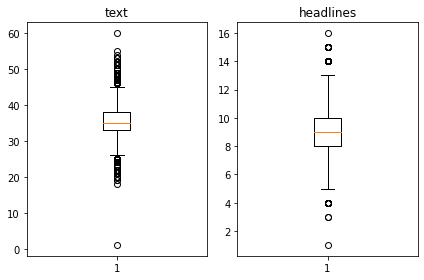

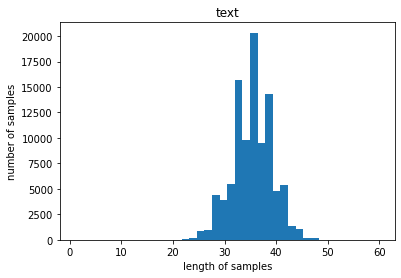

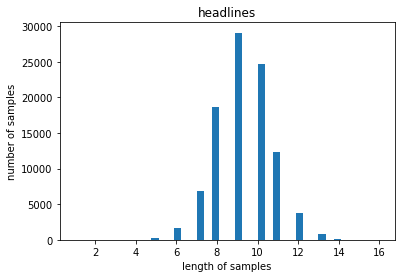

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* text의 경우 최소 길이가 1, 최대 길이가 60으로 그 차이가 좀 있다. 하지만 평균 길이는 35로 시각화된 그래프로 봤을 때는 대체적으로는 30~40 내외의 길이를 가진다는 것을 확인할 수 있다.

* headlines의 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 text에 비해 상대적으로 길이가 매우 짧다. 그래프로 봤을 때에도 대체적으로 8~10의 길이를 가지고 있다.

In [16]:
# 통계적으로 확인하기 위한 함수
# 통계로 확인해 객관적으로 길이 결정
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
# 각각 38과 11로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인
text_max_len = 38
headlines_max_len = 11

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8044261294261295
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.952014652014652


* Box plot으로 확인했을 때 3Q지점에 해당하는 38(text), 11(headlines)로 지정한다.
* 38과 11로 패딩을 하게되면 text는 약 19%, headlines는 약 6% 정도의 샘플들 내용이 망가지게 된다.
* 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제한다.

In [18]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 75215


### B. Add sostok and eostok

In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu said met u...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


* 'decoder_input'의 앞에 'sostoken' 을 추가, 'decoder_target'의 끝에는 'eostoken'을 추가

### C.  Data suffle and split

In [20]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[13238 22843 37283 ... 73352 73311 47207]


In [22]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15043


In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]   
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 60172
훈련 레이블의 개수 : 60172
테스트 데이터의 개수 : 15043
테스트 레이블의 개수 : 15043


### 2.2.4 Creating Vocabulary and Integer Encoding

### A. Encoder Train Data

In [25]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 60059
등장 빈도가 6번 이하인 희귀 단어의 수: 41037
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19022
단어 집합에서 희귀 단어의 비율: 68.3278109858639
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.115515481622759


* encoder_input_train에는 6만여 개의 단어가 있다.
* 등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 68% 이상을 차지
* 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 4.1%밖에 되지 않는다.
* 그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
* 위에서 이를 제외한 단어 집합의 크기를 만 9천여 개로 계산
* 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 19,000으로 제한

In [27]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

* 현재 단어 집합의 크기를 19,000으로 제한했으므로 이제 19,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[6385, 2941, 14, 113, 151, 54, 41, 53, 11999, 4897, 282, 59, 76, 2904, 105, 13576, 2941, 1359, 7, 1394, 782, 280, 7, 1, 72, 976, 3452, 3810, 6385, 988, 376, 4897, 290], [75, 143, 74, 9409, 3256, 10527, 264, 16656, 7021, 4378, 2267, 650, 340, 13, 46, 2267, 429, 56, 2638, 15695, 11184, 14225, 2251, 151, 54, 4, 2267, 126, 513, 476, 14925, 4898, 320, 75, 74, 1, 549], [117, 2319, 4953, 2611, 9171, 1037, 3985, 3934, 5997, 995, 95, 2319, 1907, 9171, 6203, 11, 46, 95, 6, 1286, 2611, 2319, 531, 2611, 934, 20]]


### B. Decoder Train Data

In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 26859
등장 빈도가 5번 이하인 희귀 단어의 수: 17854
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9005
단어 집합에서 희귀 단어의 비율: 66.47306303287539
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.615371220360033


* encoder_input_train에는 2만여 개의 단어가 있다.
* 등장 빈도가 threshold 값인 6회 미만, 즉 5회 이하인 단어들은 단어 집합에서 무려 66% 이상을 차지
* 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 5.6%밖에 되지 않는다.
* 그래서 등장 빈도가 5회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
* 위에서 이를 제외한 단어 집합의 크기를 8500개로 계산

In [31]:
tar_vocab = 8500
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3519, 132, 4706, 7593, 338, 103, 4, 23, 131], [1, 25, 1730, 51, 5423, 103, 10, 1364, 372, 620], [1, 242, 645, 185, 1300, 354, 2395], [1, 136, 77, 141, 3, 184, 285, 1264, 4026, 1515], [1, 6502, 1475, 1193, 53, 59, 420, 13, 4337, 3747]]
target
decoder  [[3519, 132, 4706, 7593, 338, 103, 4, 23, 131, 2], [25, 1730, 51, 5423, 103, 10, 1364, 372, 620, 2], [242, 645, 185, 1300, 354, 2395, 2], [136, 77, 141, 3, 184, 285, 1264, 4026, 1515, 2], [6502, 1475, 1193, 53, 59, 420, 13, 4337, 3747, 2]]


* 현재 단어 집합의 크기를 9000으로 제한했으므로 이제 9000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.
* 그런데 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다. 
* 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장하고 확인해본다.
* 만약 있다면 삭제한다.

In [32]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 60172
훈련 레이블의 개수 : 60172
테스트 데이터의 개수 : 15043
테스트 레이블의 개수 : 15043


### C. Padding

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### 3. Creating seq2seq with attention Model

### 3.1 Building Encoder & Decoder

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [36]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 3.2 Building Attention Mechanism

In [37]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 4. Training Model 

### 4.1 Fitting the Model With Data

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights = True)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
236/236 [==============================] - 134s 531ms/step - loss: 5.9458 - val_loss: 5.5186
Epoch 2/50
236/236 [==============================] - 125s 529ms/step - loss: 5.4021 - val_loss: 5.2563
Epoch 3/50
236/236 [==============================] - 125s 528ms/step - loss: 5.0801 - val_loss: 4.9975
Epoch 4/50
236/236 [==============================] - 125s 529ms/step - loss: 4.8318 - val_loss: 4.8265
Epoch 5/50
236/236 [==============================] - 125s 530ms/step - loss: 4.6212 - val_loss: 4.6714
Epoch 6/50
236/236 [==============================] - 126s 532ms/step - loss: 4.4376 - val_loss: 4.5514
Epoch 7/50
236/236 [==============================] - 125s 528ms/step - loss: 4.2810 - val_loss: 4.4342
Epoch 8/50
236/236 [==============================] - 124s 527ms/step - loss: 4.1403 - val_loss: 4.3406
Epoch 9/50
236/236 [==============================] - 124s 526ms/step - loss: 4.0119 - val_loss: 4.2642
Epoch 10/50
236/236 [==============================] - 124s 524m

* `EarlyStopping`을 통해 validation loss가 증가할 때 fitting을 멈춘다.
* 변수 `restore_best_weights`을 `True`로 설정하여 모델의 성능이 가장 좋은 시점(가중치가 가장 좋은 시점)을 저장한다.

### 4.2 Visualization the Validation Loss

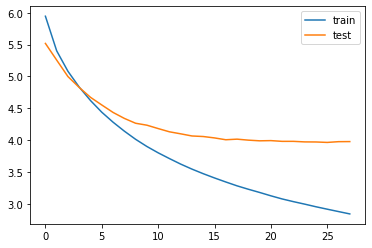

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 5. Testing Model 

### 5.1 Implementing the Inference Model

### 5.1.1 convert the index to word 

In [40]:
# 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전 준비

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 5.1.2 Setting up the Inference For the Encoder and Decoder

In [41]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = \
decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [42]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 5.1.3 Defining a Functio For Implementation of the Inference Process

In [43]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 5.1.4 Converting an Integer Sequence to a Word Sequence 

In [44]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### 5.2 Compare Headlines with Summary (Abstractive Summarization)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [45]:
for i in range(20):
    print(i+1, "-------------------------------------------------------")
    print("<원문> :", seq2text(encoder_input_test[i]))
    print("[실제 요약] :", seq2summary(decoder_input_test[i]))
    print("[예측 요약] :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

1 -------------------------------------------------------
<원문> : uttar pradesh police inspector died friday night bike hit town deceased manish yadav deployed kumbh mela duty yadav met accident returning native place following shifted hospital succumbed injuries 
[실제 요약] : up police inspector dies after bike hits 
[예측 요약] :  uttar pradesh policemen injured in uttar pradesh


2 -------------------------------------------------------
<원문> : team surgeons led indian origin professor neil malhotra university pennsylvania performed first ever robot assisted spinal surgery doctors successfully removed tumour patient neck two day procedure involved risk permanent doctors reported patient back work surgery performed august 
[실제 요약] : indian origin doctor leads st robot surgery 
[예측 요약] :  india first lady to surgery at


3 -------------------------------------------------------
<원문> : supreme court tuesday allowed two member special investigation team sit supervise probe cases related anti sik

### 5.3 Compare Headlines with Summary (Extractive Summarization)

### 5.3.1 Load Text Data

In [46]:
import requests
from summa.summarizer import summarize

In [47]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [48]:
data['text'].sample(10)

46114    A match between Juventus and Atalanta in Italy...
46165    Talking about their process of developing and ...
33497    After Chennai Super Kings' win against Royal C...
4990     The police on Sunday said that a 32-year-old w...
96709    Indian spinner Kuldeep Yadav, who registered 4...
23191    The first look of actors Kartik Aaryan and Kri...
49619    Reacting to threats calling for cutting off he...
34056    England spinner Monty Panesar, who turns 36 to...
54625    During the winter session, Law Minister Ravi S...
11218    The trailer of Rajinikanth and Akshay Kumar st...
Name: text, dtype: object

### 5.3.2 Using Summarize

* text (str) : 요약할 테스트.
* ratio (float, optional) : 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
* words (int or None, optional) : 출력에 포함할 단어 수.
* 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시
* split (bool, optional) : True면 문장 list / False는 조인(join)된 문자열을 반환

In [49]:
for i in range(10):
    print(i+1, "-------------------------------------------------------")
    print("원문 :", data['text'][i])
    print("\n")
    print("실제 요약 :", data['headlines'][i])
    print("추출적 요약(ratio) :", summarize(data["text"][i], ratio=0.5))
    print("추출적 요약(words) :", summarize(data["text"][i], words=20))
    print("\n")

1 -------------------------------------------------------
원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약(ratio) : upGrad's Online Power Learning has powered 3 lakh+ careers.
추출적 요약(words) : The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


2 -------------------------------------------------------
원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a D